<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predict West Nile virus

---
## Problem Statement

West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death. <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/4366/media/moggie2.png" style="float: right">

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. 

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

This [Kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/) is scored by AUC metric.

---
## Data description
In this competition, you will be analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species. 

**Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus** before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

#### Main dataset
These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

#### Spray data
The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4366/media/all_loc_trap.png)

#### Weather data
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. Data dictionary for this dataset is found in [`noaa_weather_qclcd_documentation.pdf`](./assets/input/noaa_weather_qclcd_documentation.pdf)

    Station 1: 
    CHICAGO O'HARE INTERNATIONAL AIRPORT 
    Lat: 41.995 Lon: -87.933 
    Elev: 662 ft. above sea level
    
    Station 2: 
    CHICAGO MIDWAY INTL ARPT 
    Lat: 41.786 Lon: -87.752 
    Elev: 612 ft. above sea level

#### Map data
The map files `mapdata_copyright_openstreetmap_contributors.rds` and `mapdata_copyright_openstreetmap_contributors.txt` are from Open Streetmap and are primarily provided for use in visualizations (but you are allowed to use them in your models if you wish).

Here's an example using `mapdata_copyright_openstreetmap_contributors.rds`, and here's one using `mapdata_copyright_openstreetmap_contributors.txt`.

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## [`clean_weather.csv`](./assets/input/clean_weather.csv)

In [6]:
df = pd.read_csv('./assets/input/clean_weather.csv', parse_dates=[0], infer_datetime_format=True)
df.head(3)

,Date,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,1,83,50,67,14,51,56,0,2,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2007-05-01,2,84,52,68,M,51,57,0,3,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,2007-05-02,1,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [7]:
# check date is datetime dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2944 non-null   datetime64[ns]
 1   Station      2944 non-null   int64         
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      1335 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

Doing this:
    
    # features Tavg and WetBulb not int64
    # to convert
    df.astype({'Tavg':'int64', 'WetBulb':'int64'}).dtypes # there are non integer values

Resulted in following error:   
    
    invalid literal for int() with base 10: 'M'

In [47]:
# find out what is error is about 
# 11 rows affected
df.loc[(df['Tavg']=='M') | (df['WetBulb']=='M'),:] 
# what does M mean

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-04,2,78,51,M,M,42,50,M,M,-,...,NaN,M,M,M,0.00,29.36,30.04,10.1,7,10.4
2008-07-08,2,86,46,M,M,68,71,M,M,-,...,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
2008-10-01,2,62,46,M,M,41,47,M,M,-,...,NaN,M,M,M,0.00,29.30,29.96,10.9,33,11.0
2009-06-26,1,86,69,78,7,60,M,0,13,0418,...,NaN,0,M,0.0,0.00,M,29.85,6.4,4,8.2
2011-07-22,2,100,71,M,M,70,74,M,M,-,...,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2012-08-22,2,84,72,M,M,51,61,M,M,-,...,NaN,M,M,M,0.00,29.39,M,4.7,19,M
2013-05-02,2,71,42,M,M,39,45,M,M,-,...,NaN,M,M,M,0.00,29.51,30.17,15.8,2,16.1
2013-08-10,1,81,64,73,0,57,M,0,8,0454,...,NaN,0,M,0.0,0.00,M,30.08,5.3,5,6.5
2013-08-11,1,81,60,71,-2,61,M,0,6,0455,...,RA,0,M,0.0,0.01,29.35,30.07,2.0,27,3.0


What does M mean?

Based on [data dictionary](./assets/input/noaa_weather_qclcd_documentation.pdf), 'M' represents missing data for other features such as SnowFall, Depth, Water1. So I would assume that 'M' for features `Tavg` and `WetBulb` also represent missing data since it was not explicitly accounted for in the dictionary for these 2 features.

In [8]:
df.isnull().sum() # null values in CodeSum feature

Date              0
Station           0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
Sunrise           0
Sunset            0
CodeSum        1609
Depth             0
Water1            0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [128]:
# do value counts for some columns that I consider to drop in the next chapter
df['Heat'].value_counts() # 11 'M'

0     1870
4       88
1       86
2       81
8       67
3       66
5       61
15      57
12      49
7       49
10      48
11      48
9       46
13      46
6       45
14      36
16      29
20      28
19      24
18      24
21      19
17      17
23      15
22      12
M       11
24       7
25       5
26       4
27       2
28       2
29       2
Name: Heat, dtype: int64

In [129]:
df['Cool'].value_counts() # 11 'M' values

 0    1147
 8     138
 5     117
12     117
10     110
 6     109
 9     107
 7     104
 4     103
13     102
11     100
 3      99
14      98
 1      93
 2      89
15      84
16      55
17      48
18      34
19      21
20      16
21      16
M       11
22       9
24       4
23       4
26       4
25       2
27       1
28       1
29       1
Name: Cool, dtype: int64

In [130]:
df.loc[df['Heat']=='M', ['Heat','Cool']] # so 'M' values are same rows for heat and cool

,Heat,Cool
Date,,
2007-05-04,M,M
2008-07-08,M,M
2008-10-01,M,M
2011-07-22,M,M
2012-08-22,M,M
2013-05-02,M,M
2013-09-24,M,M
2013-09-29,M,M
2013-10-06,M,M


In [131]:
df['Sunrise'].value_counts() # significant amount of missing data

-       1472
0416     104
0417      64
0419      40
0422      32
        ... 
0514       8
0513       8
0512       8
0511       8
0623       8
Name: Sunrise, Length: 122, dtype: int64

In [132]:
df['Sunset'].value_counts() #significant amount of missing data

-       1472
1931      96
1930      56
1929      48
1927      32
        ... 
1822       8
1824       8
1827       8
1829       8
1647       8
Name: Sunset, Length: 119, dtype: int64

In [133]:
df['Depth'].value_counts() # significant number of missing data

0    1472
M    1472
Name: Depth, dtype: int64

In [125]:
# missing values in Depth
df.loc[df['Depth']=='M', :] # 1472 all from weather station 2

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,2,67,48,58,M,40,50,7,0,-,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
2007-05-04,2,78,51,M,M,42,50,M,M,-,...,NaN,M,M,M,0.00,29.36,30.04,10.1,7,10.4
2007-05-05,2,66,54,60,M,39,50,5,0,-,...,NaN,M,M,M,T,29.46,30.09,11.2,7,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-27,2,79,54,67,M,52,59,0,2,-,...,RA,M,M,M,0.02,29.00,29.67,12.7,19,13.6
2014-10-28,2,66,48,57,M,40,48,8,0,-,...,RA,M,M,M,0.03,29.23,29.85,14.0,26,14.6
2014-10-29,2,49,40,45,M,34,42,20,0,-,...,NaN,M,M,M,0.00,29.42,30.07,8.5,29,9.0


In [134]:
df['Water1'].value_counts() # all missing data

M    2944
Name: Water1, dtype: int64

In [135]:
df['SnowFall'].value_counts() # significant missing data

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [136]:
df['StnPressure'].value_counts() # # this feature was classified as 'object' dtype by Pandas

29.34    128
29.28    124
29.26    123
29.21    107
29.31    106
        ... 
28.88      1
28.59      1
28.67      1
28.75      1
28.83      1
Name: StnPressure, Length: 104, dtype: int64

In [142]:
df.loc[df['StnPressure']=='M', ['StnPressure']] # 4 missing values

,StnPressure
Date,
2007-06-13,M
2009-06-26,M
2013-08-10,M
2013-08-10,M


In [137]:
df['SeaLevel'].value_counts() # this feature was classified as 'object' dtype by Pandas

30.00    96
29.98    85
29.94    85
29.92    83
29.89    82
         ..
29.25     1
29.23     1
29.46     1
29.43     1
29.47     1
Name: SeaLevel, Length: 102, dtype: int64

In [143]:
display(df.loc[df['SeaLevel']=='M', ['SeaLevel']])
display(len(df.loc[df['SeaLevel']=='M', ['SeaLevel']])) # 9 missing values

,SeaLevel
Date,
2007-06-13,M
2009-06-18,M
2009-09-07,M
2011-09-08,M
2011-09-14,M
2011-09-20,M
2012-08-22,M
2012-09-03,M
2014-07-23,M


9

In [138]:
df['ResultSpeed'].value_counts() # no str data

5.9     49
6.4     47
5.3     42
6.2     42
4.9     38
        ..
0.2      1
21.1     1
16.0     1
22.7     1
21.7     1
Name: ResultSpeed, Length: 190, dtype: int64

In [139]:
df['ResultDir'].value_counts() # no str data

21    156
3     139
19    138
23    138
24    122
4     121
20    118
22    116
5     113
6     111
2     110
25    106
7      98
26     94
18     84
27     83
28     78
36     72
29     71
8      68
30     64
9      63
1      62
31     61
17     59
11     59
16     55
12     50
14     49
34     49
32     47
10     45
13     38
35     37
15     36
33     34
Name: ResultDir, dtype: int64

In [140]:
df['AvgSpeed'].value_counts() # this feature was classified as 'object' dtype by Pandas

6.9     63
5.8     60
7.4     55
8.1     49
7.0     47
        ..
16.2     1
21.5     1
20.2     1
18.4     1
22.6     1
Name: AvgSpeed, Length: 178, dtype: int64

In [145]:
df.loc[df['AvgSpeed']=='M', ['AvgSpeed']] # 3 missing values

,AvgSpeed
Date,
2007-06-13,M
2011-09-14,M
2012-08-22,M


In [126]:
df.loc[df['PrecipTotal']=='M', :] # only 2 missing data in PrecipTotal feature, so can keep

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-28,2,73,61,67,M,56,61,0,2,-,...,NaN,M,M,M,M,29.43,30.07,12.2,2,13.3
2007-06-29,2,71,56,64,M,56,60,1,0,-,...,NaN,M,M,M,M,29.47,30.11,7.4,2,8.2


In [154]:
df['PrecipTotal'].value_counts(dropna=False)

0.00    1568
  T      316
0.01     127
0.02      63
0.03      46
        ... 
3.64       1
4.73       1
1.60       1
2.24       1
1.18       1
Name: PrecipTotal, Length: 168, dtype: int64

In [9]:
df.shape

(2944, 22)

In [10]:
df.set_index('Date', inplace=True) # set date as index

In [11]:
df.sort_index(inplace=True) # just in case not sorted by date already

In [13]:
df.head(3)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [14]:
df.index.value_counts().sort_index() # 1472 unique dates
# interesting that all values are 2

2007-05-01    2
2007-05-02    2
2007-05-03    2
2007-05-04    2
2007-05-05    2
             ..
2014-10-27    2
2014-10-28    2
2014-10-29    2
2014-10-30    2
2014-10-31    2
Name: Date, Length: 1472, dtype: int64

In [15]:
df.loc[df.index.value_counts().sort_index()!=2, :] # all date counts are 2
# means all dates have 2 entries each

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,


In [16]:
df.head(5) # looks like 2 weather stations reporting weather data daily

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,NaN,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [19]:
pd.DataFrame({'station': [1,2],
             'latitude':[41.995, 41.786],
             'longitude':[-87.933, -87.752]}).set_index('station')

,latitude,longitude
station,,
1,41.995,-87.933
2,41.786,-87.752


In [36]:
# plot weather stations on map
# function to plot data on map
def map_data():
    mapdata = np.loadtxt("./assets/input/mapdata_copyright_openstreetmap_contributors.txt")
    all_stations = pd.DataFrame({'station': [1,2],
                                 'latitude':[41.995, 41.786],
                                 'longitude':[-87.933, -87.752]}).set_index('station')

    # set up base map
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88.1, -87.5, 41.6, 42.0)

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
 
    # plot base data
    all_locations = all_stations[['longitude', 'latitude']].values
    plt.scatter(all_locations[0,0], all_locations[0,1], marker='P', color='steelblue')
    plt.scatter(all_locations[1,0], all_locations[1,1], marker='D', color='red')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('A Plot of weather stations')
    plt.legend(['station 1', 'station 2'], loc='upper right');

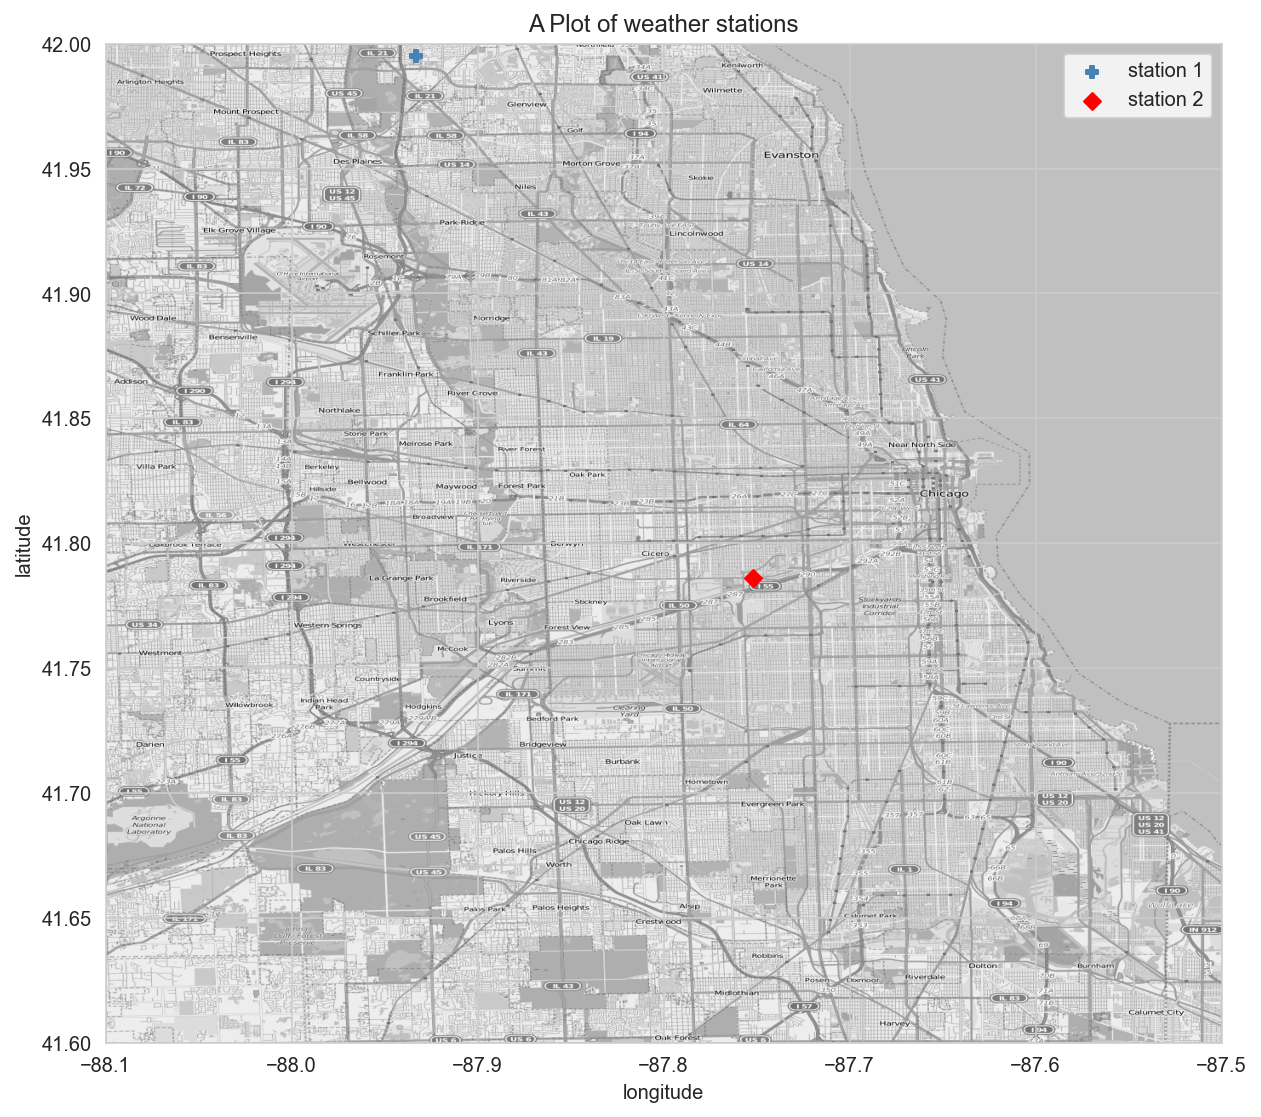

In [37]:
map_data()

In [49]:
# groupby month and check temperature trend
df.resample('M').agg({'Tmax':'mean', 'Tmin':'mean', 'DewPoint':'mean'}).head()

,Tmax,Tmin,DewPoint
Date,,,
2007-05-31,75.758065,53.032258,45.790323
2007-06-30,81.433333,62.516667,56.600000
2007-07-31,83.177419,64.709677,58.838710
2007-08-31,83.048387,67.145161,64.096774
2007-09-30,79.200000,58.316667,53.050000


In [53]:
df.resample('Y')['Tmax'].agg('mean') # there is data for every year between 2007 and 2014

Date
2007-12-31    78.480978
2008-12-31    75.013587
2009-12-31    72.510870
2010-12-31    77.521739
2011-12-31    75.769022
2012-12-31    78.687500
2013-12-31    75.932065
2014-12-31    75.413043
Freq: A-DEC, Name: Tmax, dtype: float64

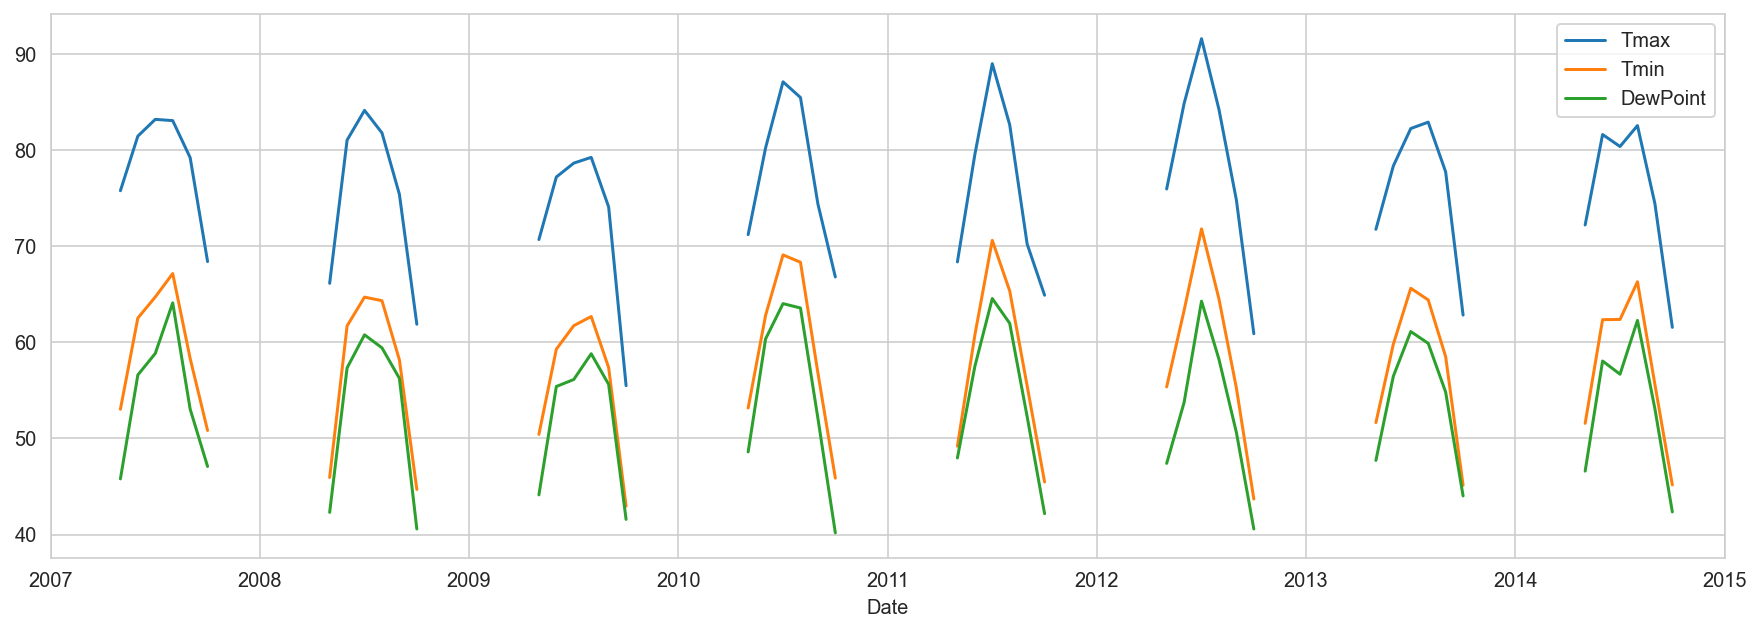

In [67]:
# plot trend
df.resample('M').agg({'Tmax':'mean', 'Tmin':'mean', 'DewPoint':'mean'}).plot(kind='line', 
                                                                             xticks=['2007','2008','2009','2010','2011','2012','2013','2014', '2015'],
                                                                             figsize=(15,5));

In [98]:
df.loc['2007'].resample('M').agg({'Tmax':'mean', 'Tmin':'mean', 'DewPoint':'mean'})

,Tmax,Tmin,DewPoint
Date,,,
2007-05-31,75.758065,53.032258,45.790323
2007-06-30,81.433333,62.516667,56.600000
2007-07-31,83.177419,64.709677,58.838710
2007-08-31,83.048387,67.145161,64.096774
2007-09-30,79.200000,58.316667,53.050000
2007-10-31,68.387097,50.822581,47.080645


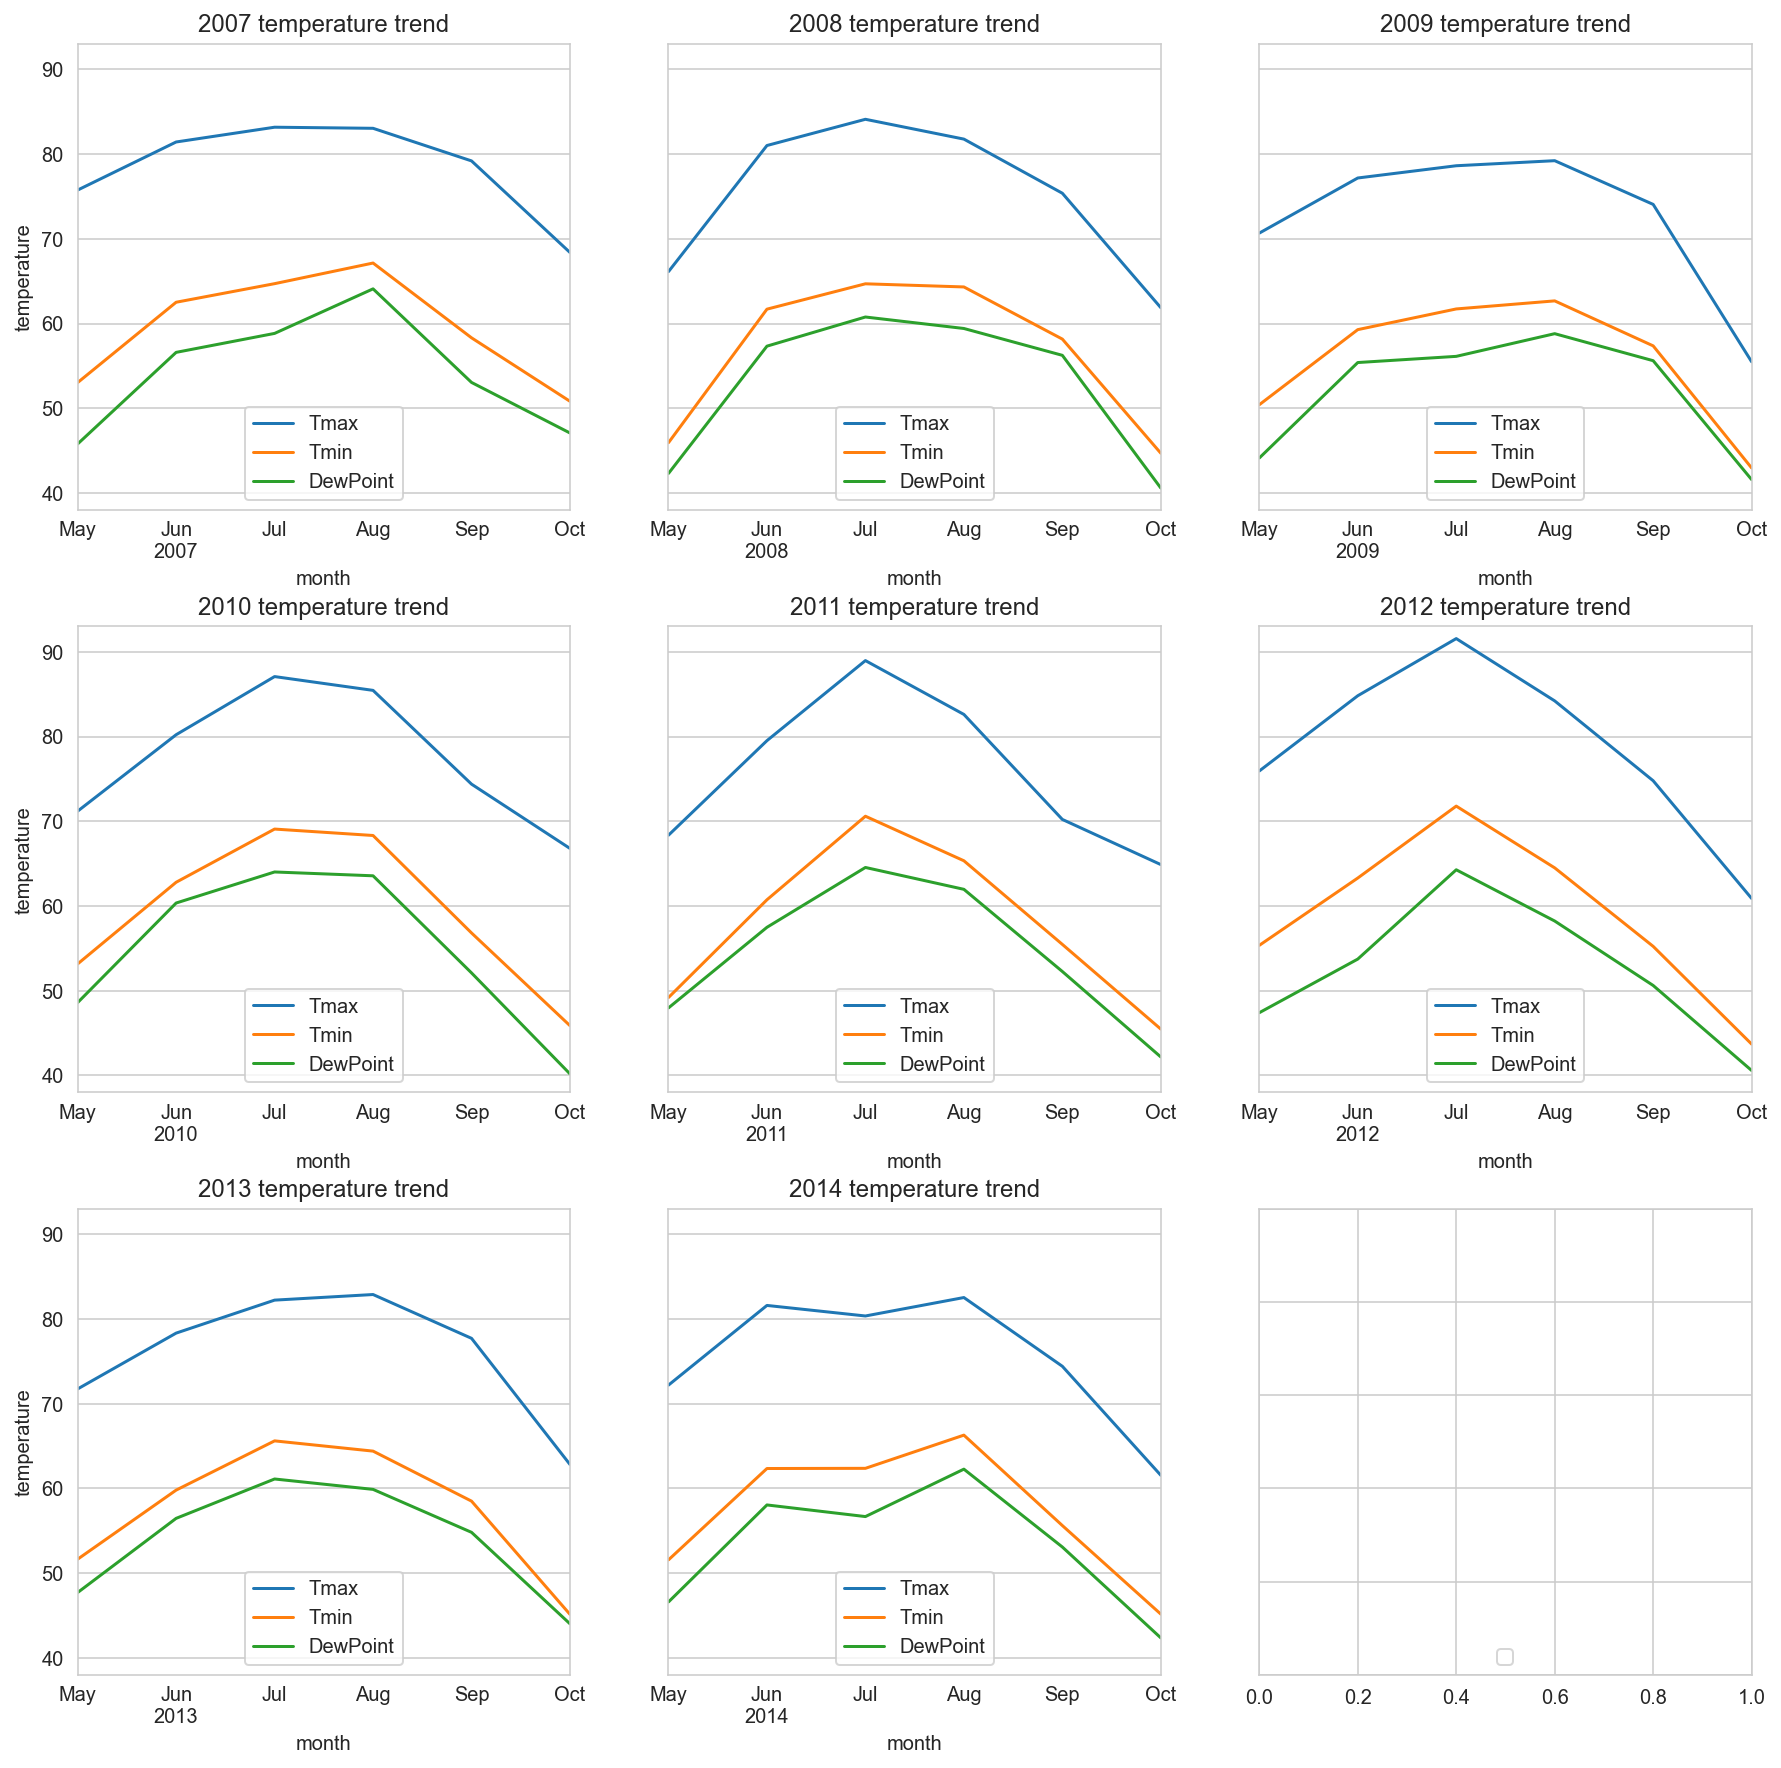

In [117]:
# a more granular plot by each year
# function to plot by year
def temp_plot(year, ax): 
    df.loc[year].resample('M').agg({'Tmax':'mean', 'Tmin':'mean', 'DewPoint':'mean'}).plot(kind='line', 
                                                                            ylabel='temperature',
                                                                            xlabel='month', 
                                                                            ax = ax,
                                                                            ylim=(38,93),               
                                                                            sharey=True,
                                                                            figsize=(15,15)
                                                                            )
fig, axes = plt.subplots(3, 3) # 3 rows 3 column plot grid

temp_plot('2007', ax=axes[0,0])
axes[0,0].set_title('2007 temperature trend')
temp_plot('2008', ax=axes[0,1])
axes[0,1].set_title('2008 temperature trend')
temp_plot('2009', ax=axes[0,2])
axes[0,2].set_title('2009 temperature trend')
temp_plot('2010', ax=axes[1,0])
axes[1,0].set_title('2010 temperature trend')
temp_plot('2011', ax=axes[1,1])
axes[1,1].set_title('2011 temperature trend')
temp_plot('2012', ax=axes[1,2])
axes[1,2].set_title('2012 temperature trend')
temp_plot('2013', ax=axes[2,0])
axes[2,0].set_title('2013 temperature trend')
temp_plot('2014', ax=axes[2,1])
axes[2,1].set_title('2014 temperature trend')

for ax in axes.flat: # to iterate each subplot legend position
    ax.legend(labels=['Tmax','Tmin','DewPoint'], loc='lower center') 
plt.subplots_adjust(hspace=0.25) # space between subplots


<AxesSubplot:xlabel='Date'>

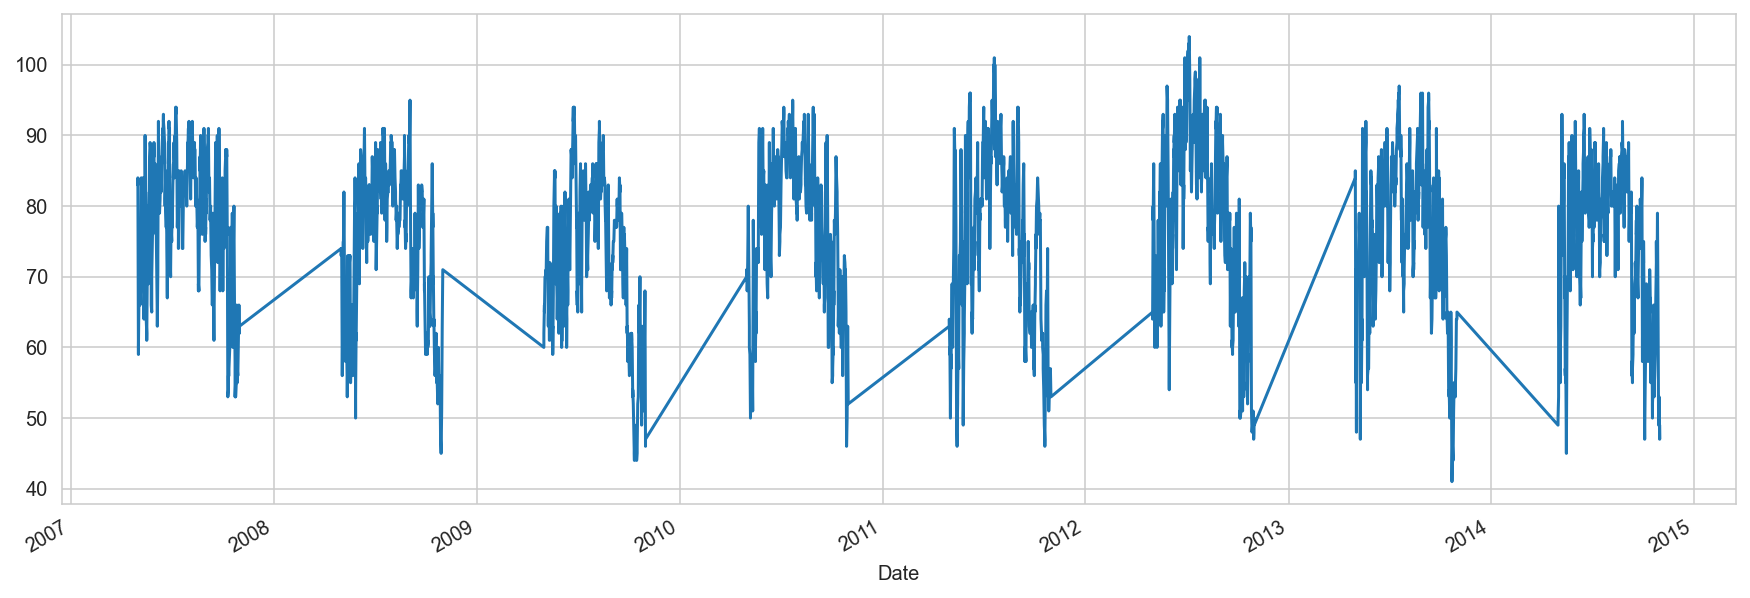

In [57]:
# plot trend
df['Tmax'].plot(kind='line', figsize=(15,5));

In [62]:
# why are the graphs above look so weird? with gaps between curves? 
# taking 2007 as an example to find out why
df.loc['2007'] # this shows that temperature were measured only between May and Oct of each year

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,NaN,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-10-29,2,60,39,50,M,32,42,15,0,-,...,NaN,M,M,M,0.00,29.70,30.41,9.1,22,9.3
2007-10-30,1,66,41,54,8,38,46,11,0,0622,...,NaN,0,M,0.0,0.00,29.43,30.20,12.2,20,12.5
2007-10-30,2,66,42,54,M,37,46,11,0,-,...,NaN,M,M,M,0.00,29.51,30.22,10.8,20,10.9


The date range for weather data is slightly longer than for main data set (train.csv)

    train.csv yearly date range: late May to early Oct (2007, 2009, 2011, 2013)
    weather data yearly date range: early May to late Oct (2007-2014)
    spray data is sporadic: only 10 unique dates (2 dates in 2011, 8 dates in 2013)

In [124]:
df.columns

Index(['Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

Next steps, I would like to explore the following relationships:
* if temperature has any effect on mosquito count. (based on 2 regions North and South)
* if humidity / rainfall has any effect on mosquito count (based by 2 regions North and South)
* if spraying affects mosquito count (explore by region and for years 2011 and 2013)
  * useful to know if mosquito counts are significantly less in 2011 and 2013 compared to 2009 and 2007
* if mosquito count is related to probability of being west nile virus positive

For that, I need to somehow merge the data from [train.csv](./assets/input/train.csv) and [weather.csv](./assets/input/clean_weather.csv)